In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import collections
from local_utils import *

In [2]:
#load data
def load_data():
    data = pd.read_csv('./data/tilos_hourly.csv')
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['value'] = data['value'].astype(np.float32)
    #rename the datetime column to 'DHH'
    data = data.rename(columns={'datetime':'DHH'})
    data = data.rename(columns={'value':'kW/h'})
    return data

df = load_data()
df

,DHH,kW/h
0,2021-01-01 00:00:00,250.770004
1,2021-01-01 01:00:00,231.770004
2,2021-01-01 02:00:00,222.869995
3,2021-01-01 03:00:00,221.369995
4,2021-01-01 04:00:00,220.429993
...,...,...
4219,2021-06-25 19:00:00,456.130005
4220,2021-06-25 20:00:00,502.700012
4221,2021-06-25 21:00:00,533.200012
4222,2021-06-25 22:00:00,526.369995


In [3]:
WINDOW_SIZE = 24
STEP_SIZE = 1

train_data, test_data, scaler = train_test_split_and_scale(df, 0.8)
X, Y = create_sliding_window (train_data, WINDOW_SIZE, STEP_SIZE)
X_test, Y_test = create_sliding_window (test_data, WINDOW_SIZE, STEP_SIZE)

print(X.shape, Y.shape, X_test.shape, Y_test.shape)

(3355, 24, 1) (3355,) (821, 24, 1) (821,)


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input((WINDOW_SIZE,1)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(1)
    ])
    return model

early_stopping = EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=6,         # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restores the model weights from the epoch with the best performance
)

In [5]:
loss = tf.keras.losses.MeanSquaredError()

metrics = [
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError()
]

# Define and compile model
model = create_model()
model.compile(loss=loss,
                optimizer=Adam(learning_rate=0.001),
                metrics=metrics)

# Train model
model.fit(X, Y, epochs=20, callbacks=[early_stopping])

# Evaluation
test_loss, test_mae, test_rmse, = model.evaluate(X_test, Y_test)
train_loss, train_mae, train_rmse = model.evaluate(X, Y)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0345 - mean_absolute_error: 0.1394 - root_mean_squared_error: 0.1781
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0722 - root_mean_squared_error: 0.0930
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0542 - root_mean_squared_error: 0.0715
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0447 - root_mean_squared_error: 0.0612
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0413 - root_mean_squared_error: 0.0578
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0553
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - mean_absolute_error: 0.0383 - root_mean_squared_error: 0.0564
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - mean_absolute_

In [6]:
predictions = model.predict(X_test)

actual_values = np.array(Y_test).reshape(-1,1)
predicted_values = np.array(predictions).reshape(-1,1)
actual_values_unscaled = scaler.inverse_transform(actual_values)
predicted_values_unscaled = scaler.inverse_transform(predicted_values)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [7]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate the metrics
mse = mean_squared_error(actual_values_unscaled, predicted_values_unscaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values_unscaled, predicted_values_unscaled)

# Print the metrics (optional)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE'],
    'Value': [mse, rmse, mae]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('metrics_LSTM.csv', index=False)

# Print confirmation (optional)
print('Metrics saved to metrics_LSTM.csv')


Mean Squared Error (MSE): 734.7388305664062
Root Mean Squared Error (RMSE): 27.10606575012207
Mean Absolute Error (MAE): 16.372411727905273
Metrics saved to metrics_LSTM.csv


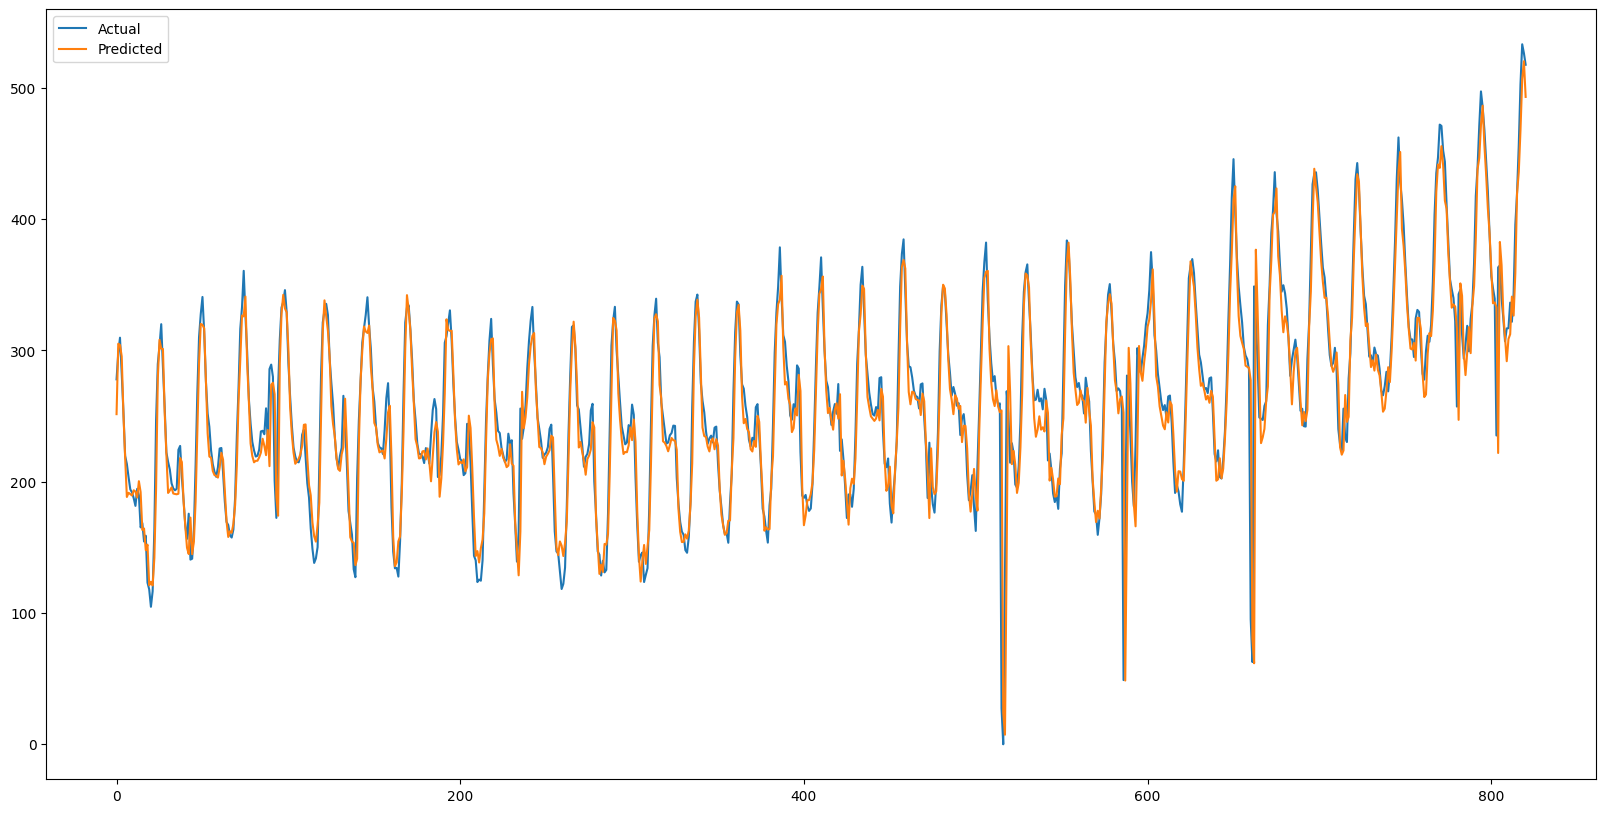

In [7]:

plt.figure(figsize=(20,10))
plt.plot(actual_values_unscaled, label='Actual')
plt.plot(predicted_values_unscaled, label='Predicted')
plt.legend()
plt.show()


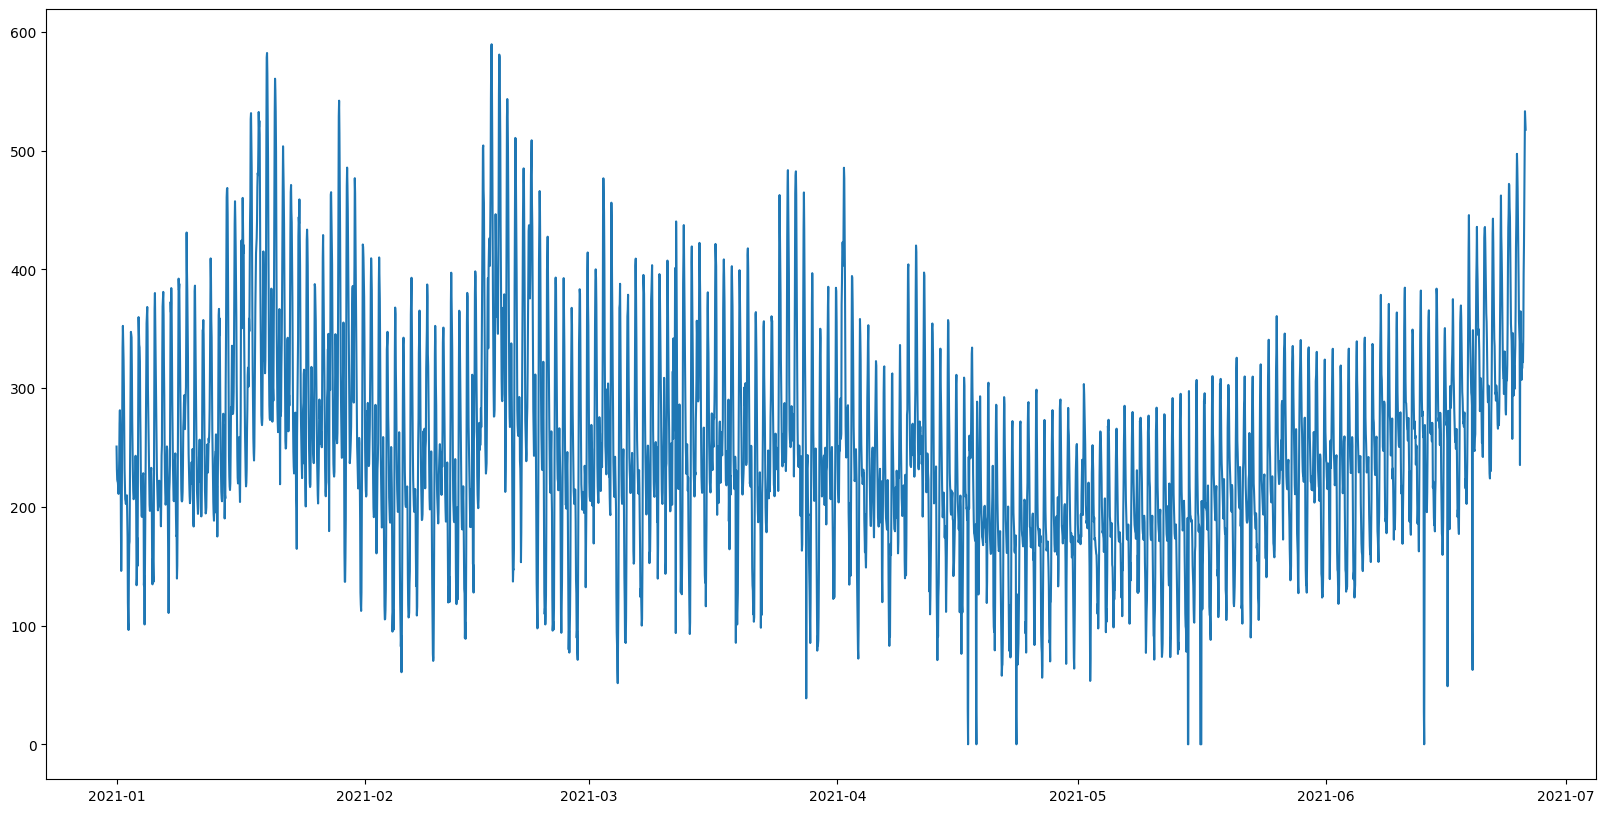

In [12]:
# i want to plot the original dataframe timeseries by setting the index to the 'DHH' column
df = df.set_index('DHH')
plt.figure(figsize=(20,10))
plt.plot(df)
plt.show()


In [11]:
df

,DHH,kW/h
0,2021-01-01 00:00:00,250.770004
1,2021-01-01 01:00:00,231.770004
2,2021-01-01 02:00:00,222.869995
3,2021-01-01 03:00:00,221.369995
4,2021-01-01 04:00:00,220.429993
...,...,...
4219,2021-06-25 19:00:00,456.130005
4220,2021-06-25 20:00:00,502.700012
4221,2021-06-25 21:00:00,533.200012
4222,2021-06-25 22:00:00,526.369995


In [13]:
actual_values_unscaled

array([[277.97   ],
       [298.     ],
       [309.7    ],
       [282.57   ],
       [253.2    ],
       [219.63   ],
       [213.5    ],
       [203.33   ],
       [194.16998],
       [191.87   ],
       [187.36   ],
       [181.6    ],
       [194.57   ],
       [189.6    ],
       [165.2    ],
       [168.5    ],
       [154.43   ],
       [158.86998],
       [123.17   ],
       [118.     ],
       [104.73001],
       [116.53   ],
       [163.36   ],
       [246.7    ],
       [289.63   ],
       [303.53   ],
       [320.     ],
       [287.2    ],
       [256.77   ],
       [222.36998],
       [215.1    ],
       [209.27   ],
       [198.83   ],
       [194.9    ],
       [193.43   ],
       [194.63   ],
       [224.3    ],
       [227.26999],
       [203.43   ],
       [186.     ],
       [166.82999],
       [156.47   ],
       [175.63   ],
       [140.67   ],
       [141.37   ],
       [163.33   ],
       [212.3    ],
       [267.3    ],
       [310.07   ],
       [327.7    ],


: 

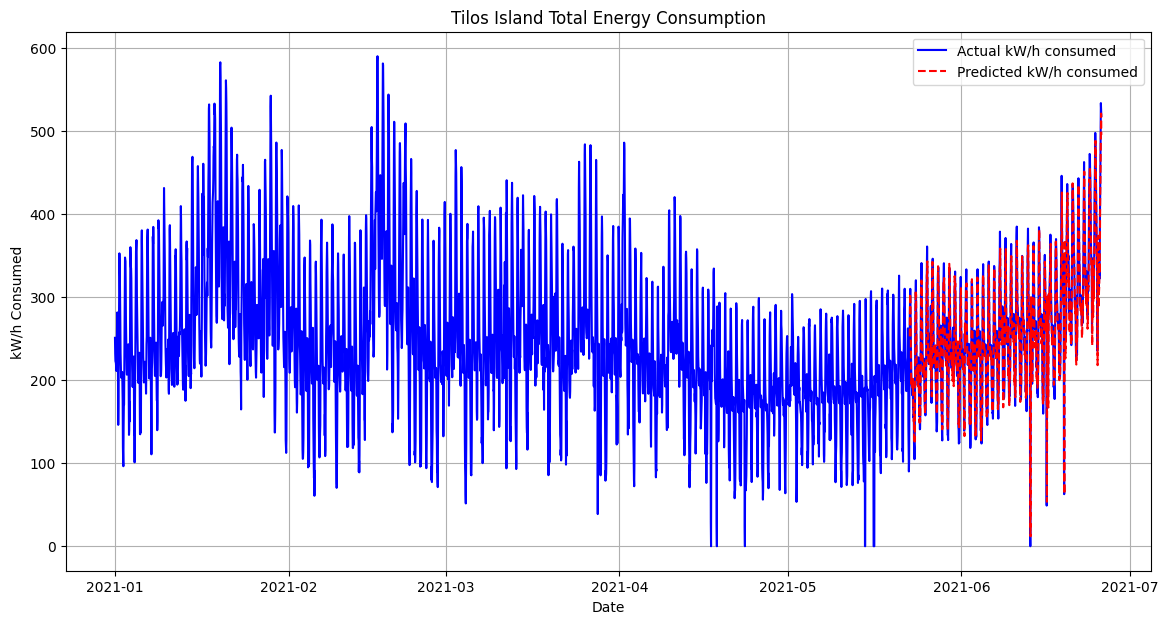

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(df['DHH'], df['kW/h'], label='Actual kW/h consumed', color='blue')
plt.plot(df['DHH'][-len(predicted_values_unscaled):], predicted_values_unscaled, label='Predicted kW/h consumed', color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('kW/h Consumed')
plt.title('Tilos Island Total Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


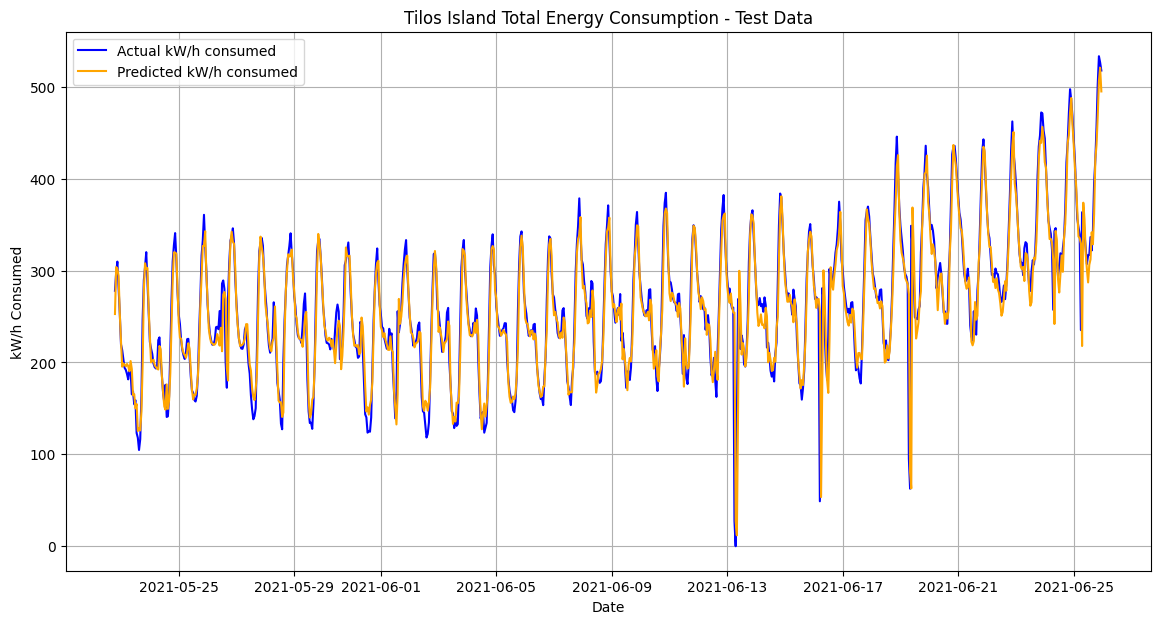

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming `scaler` and `model` are already defined
# Assuming `X_test`, `Y_test` are already defined

predictions = model.predict(X_test)

actual_values = np.array(Y_test).reshape(-1,1)
predicted_values = np.array(predictions).reshape(-1,1)
actual_values_unscaled = scaler.inverse_transform(actual_values)
predicted_values_unscaled = scaler.inverse_transform(predicted_values)

# Load the data

# Ensure the test data part is aligned with the original dataframe
test_dates = df['DHH'][-len(actual_values_unscaled):]

# Plotting the test data results
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actual_values_unscaled, label='Actual kW/h consumed', color='blue')
plt.plot(test_dates, predicted_values_unscaled, label='Predicted kW/h consumed', color='orange')

plt.xlabel('Date')
plt.ylabel('kW/h Consumed')
plt.title('Tilos Island Total Energy Consumption - Test Data')
plt.legend()
plt.grid(True)
plt.show()
